# Adversarial Validation の実装

## ライブラリのインストール

In [1]:
# 以下のライブラリを pip でインストール
## wget : データのダウンロードに使用
## sweetviz : データの可視化に使用
## optuna : モデルのハイパーパラメータ最適化に使用
## japanize-matplotlib : 図に日本語を挿入するために使用

!pip install -q wget sweetviz optuna japanize-matplotlib

## ライブラリのインポート

In [2]:
# データのダウンロードに使用
import wget

# データの前処理に使用
import numpy as np
import pandas as pd

# 可視化に使用
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import sweetviz as sv

# モデルの評価やデータの分割、カテゴリ変数の変換に使用
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import optuna.integration.lightgbm as lgb_opt

# ハイパーパラメータ最適化
import optuna

# Warning を非表示にする
import warnings
warnings.simplefilter('ignore')

## データのダウンロード

In [3]:
# abaloan データセットをダウンロード
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data')

'abalone (2).data'

## データの確認と前処理

In [4]:
# データセットを読み込む
df = pd.read_csv('abalone.data', # 読み込みデータのパス
            header=None, # 元データは列名なし
            names=[ # 新しく以下の列名を付与
                '性別', 
                '殻の長さ(mm)',
                '殻の高さ(mm)',
                '身の高さ(mm)',
                '全体の重さ(g)',
                '身の重さ(g)',
                '血抜き後の腸の重さ(g)',
                '乾燥後の殻の重さ(g)',
                '殻の年輪の数' # 今回の目的変数
            ]
            )

# [性別] 列を文字列から整数に変換
ord = OrdinalEncoder()
df['性別'] = ord.fit_transform(df[['性別']])

## ホールドアウト法による分割

In [5]:
# 今回は全体の 7 割を訓練、残り 3 割をテストとする
df_train = df[:int(len(df)*0.7)] # 訓練データ
df_test = df[int(len(df)*0.7):] # テストデータ

In [6]:
# [train/valid/test] 列を新たに作成する（Adversarial Validation 時のラベルになる）
df_train['train/valid/test'] = 'train' # 訓練データ
df_test['train/valid/test'] = 'test' # テストデータ

## データの可視化

                                             |          | [  0%]   00:00 -> (? left)


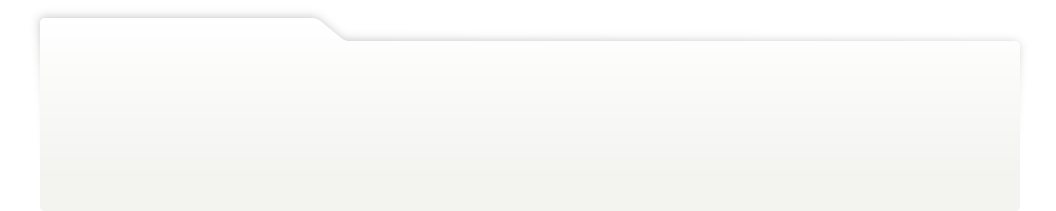
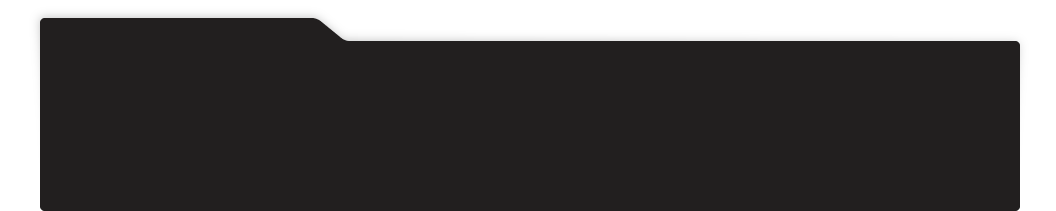
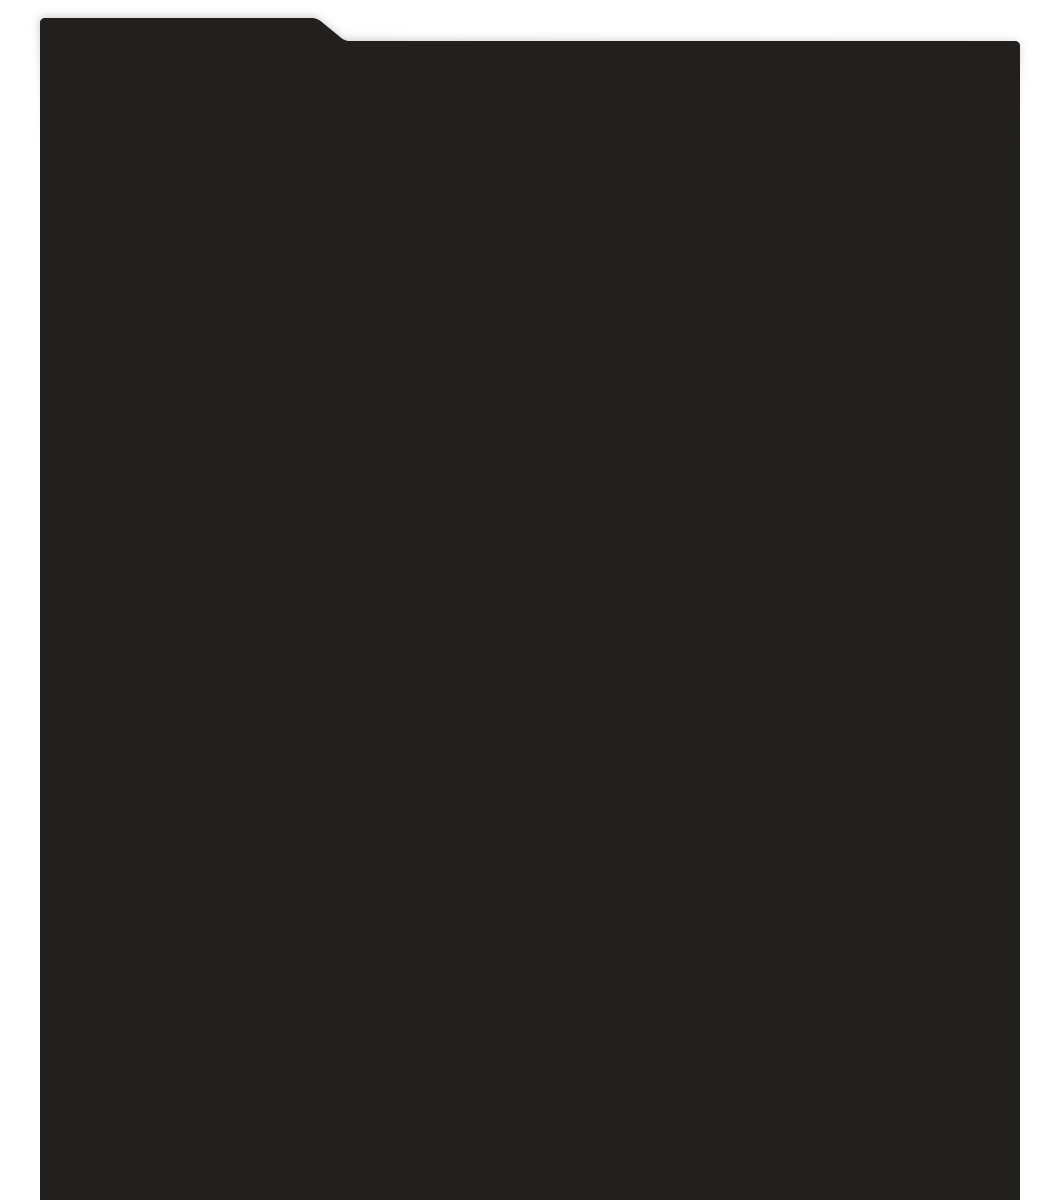
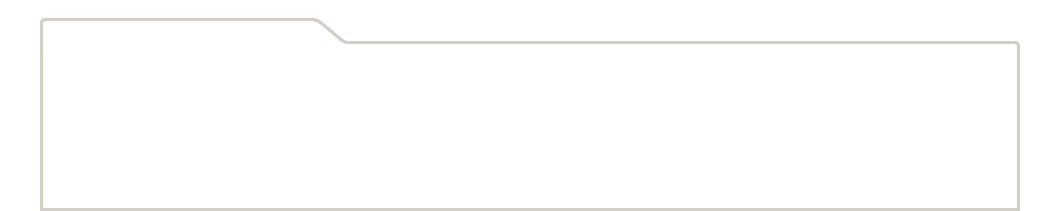
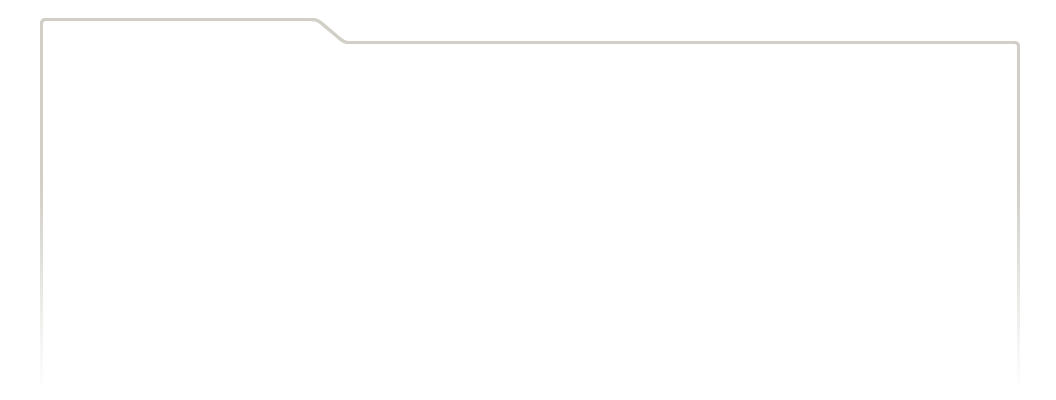
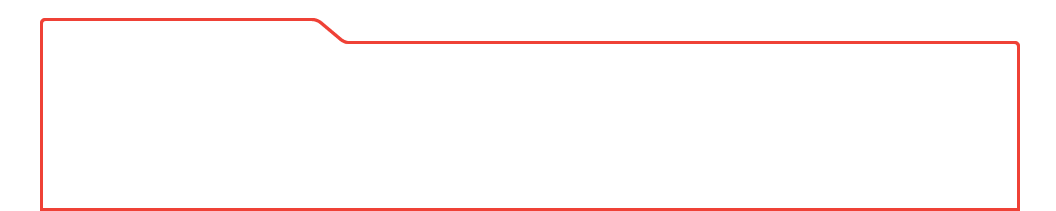
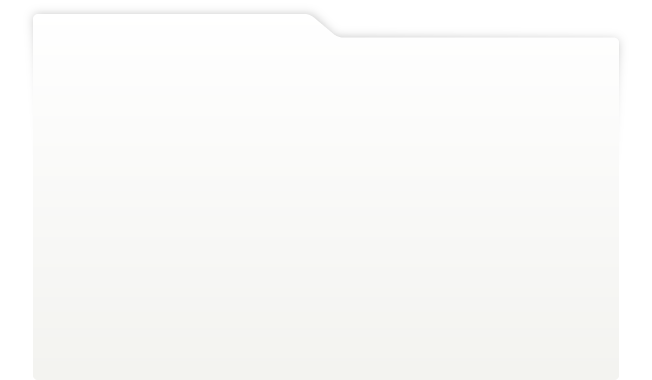
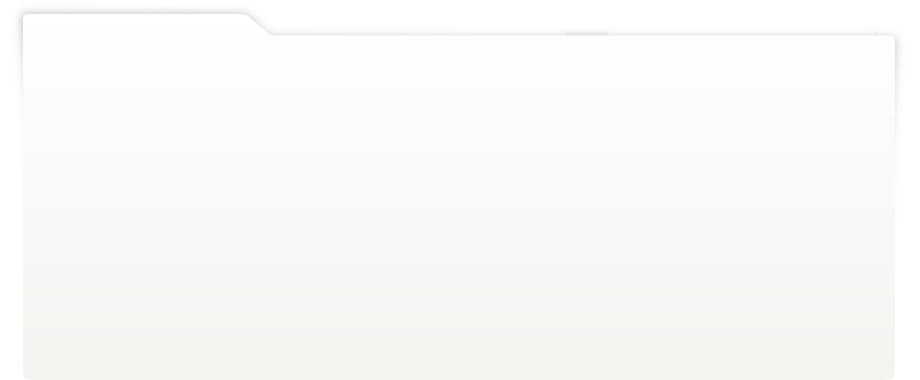
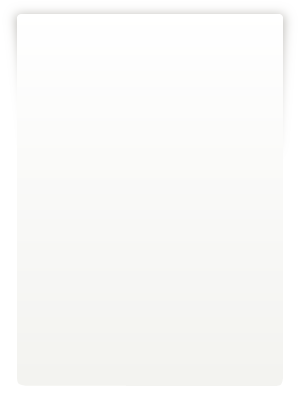
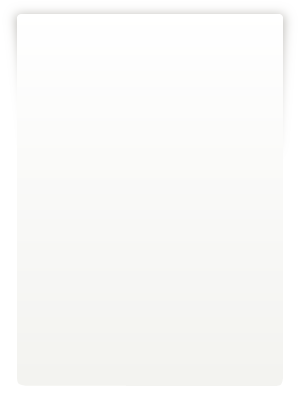
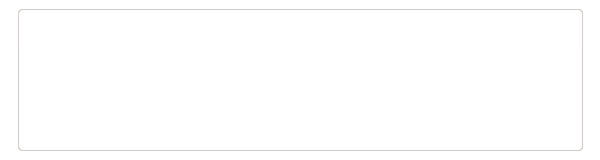
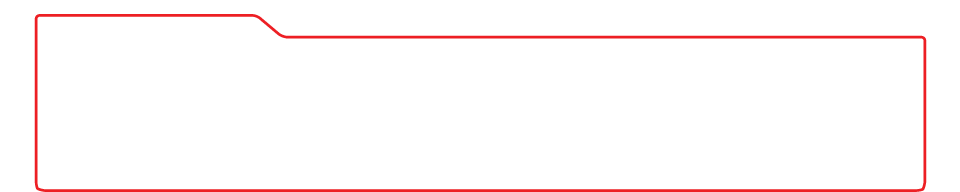
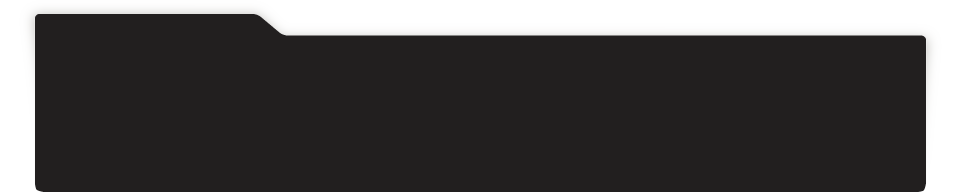
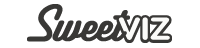
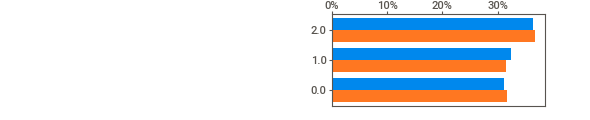
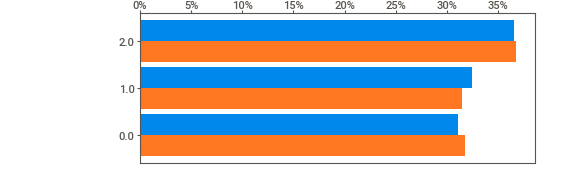
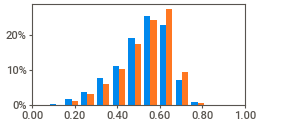
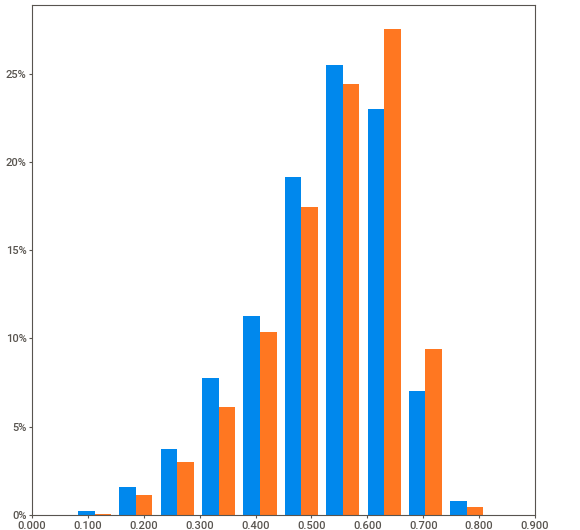
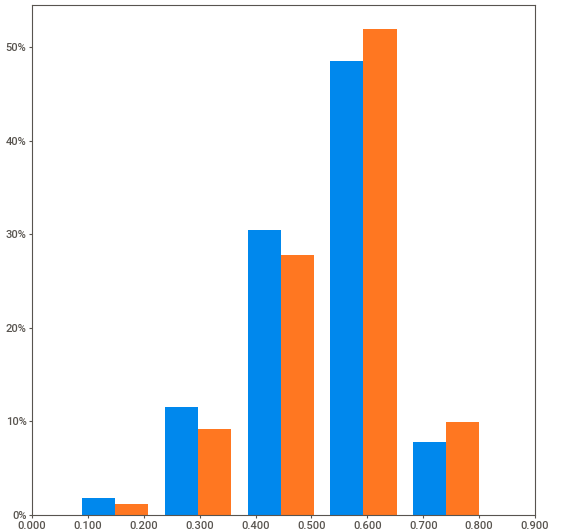
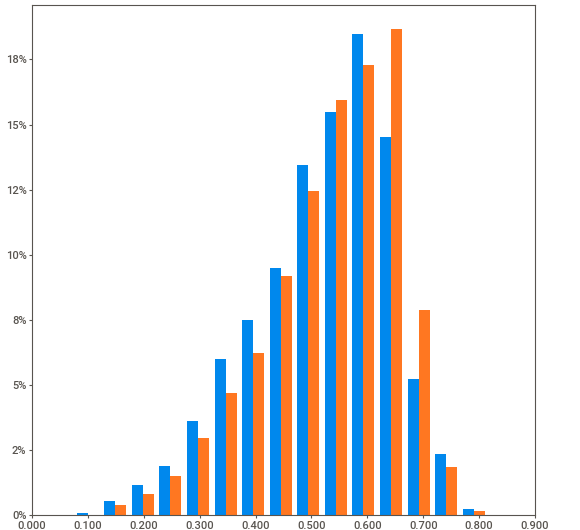
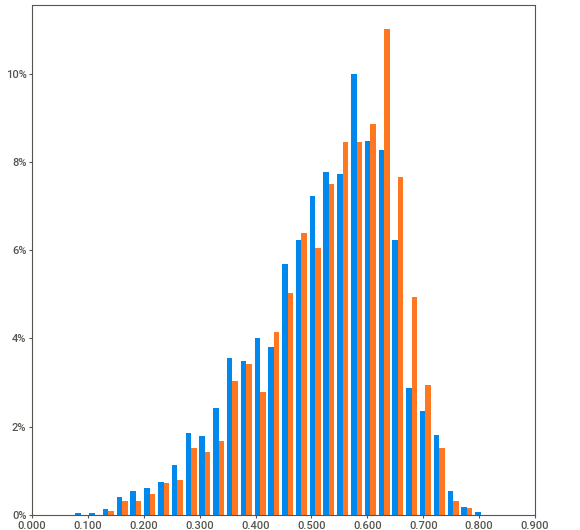
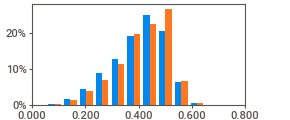
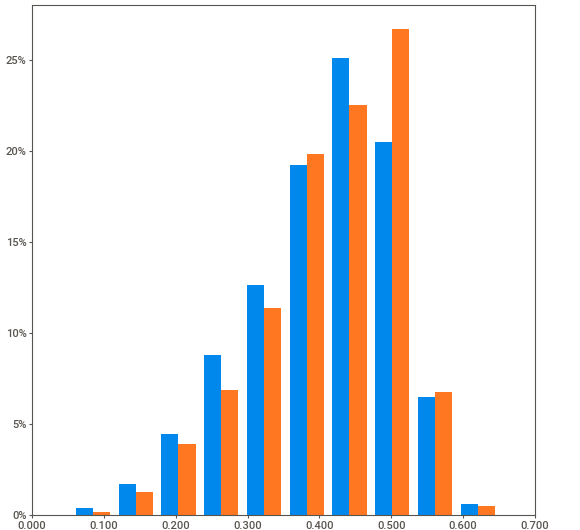
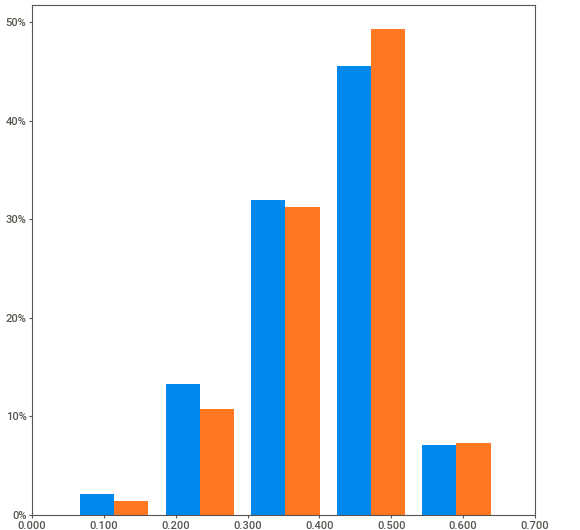
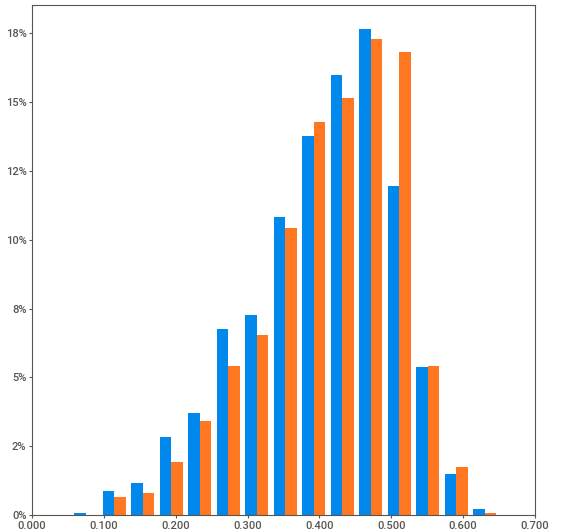
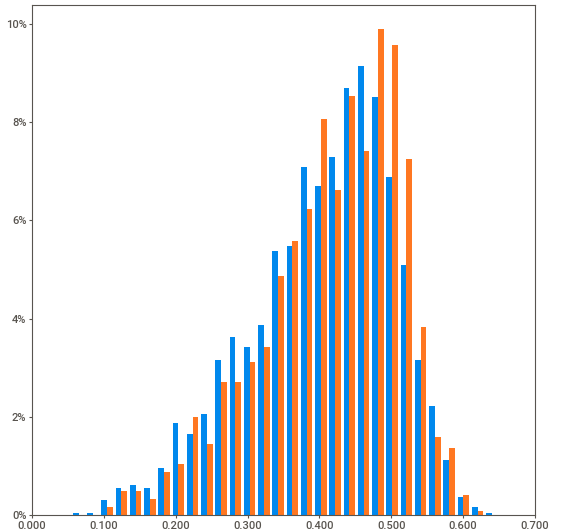
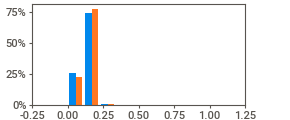
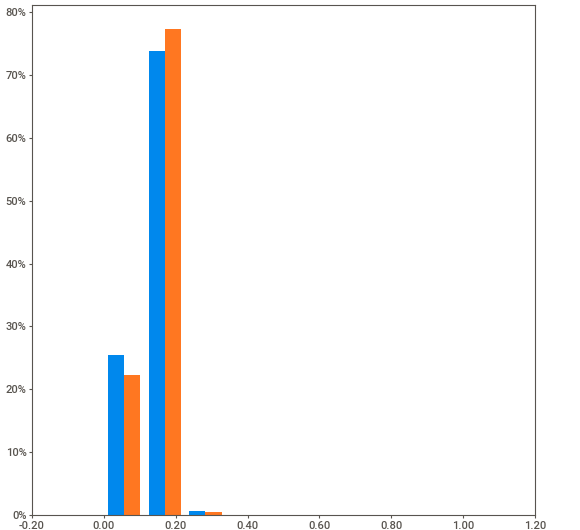
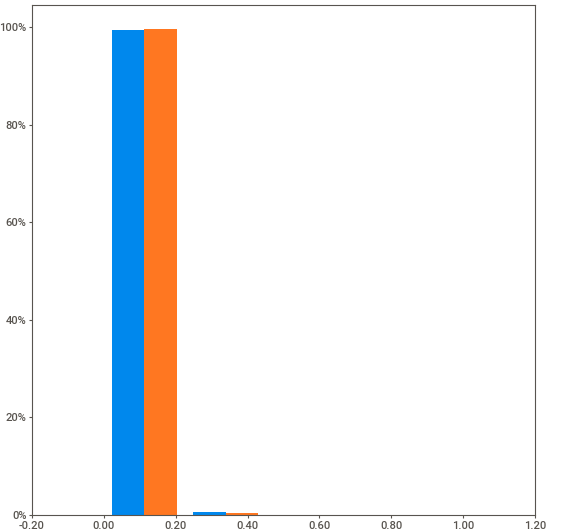
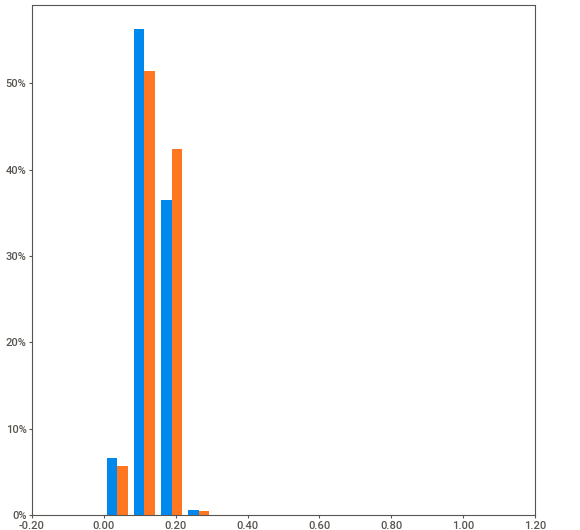
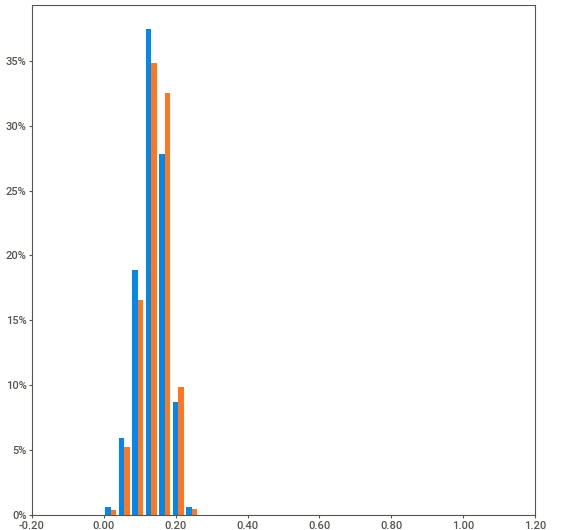
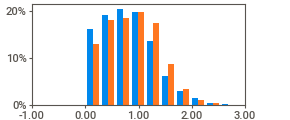
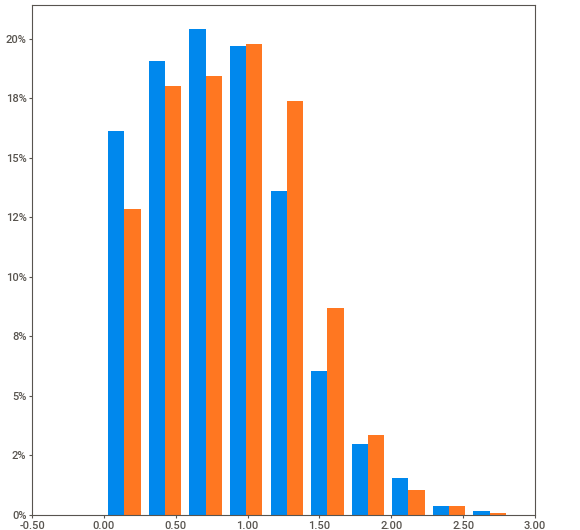
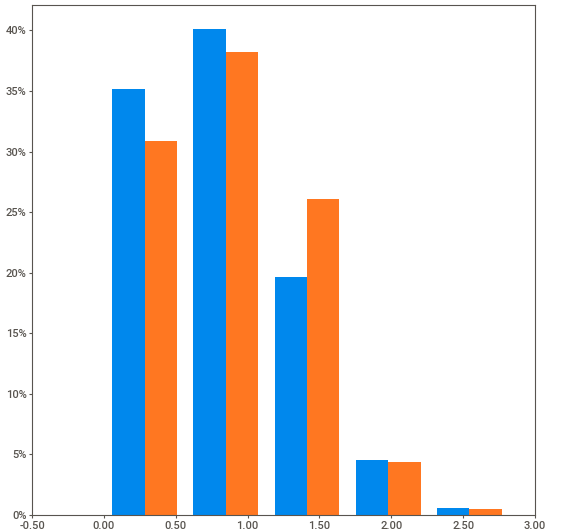
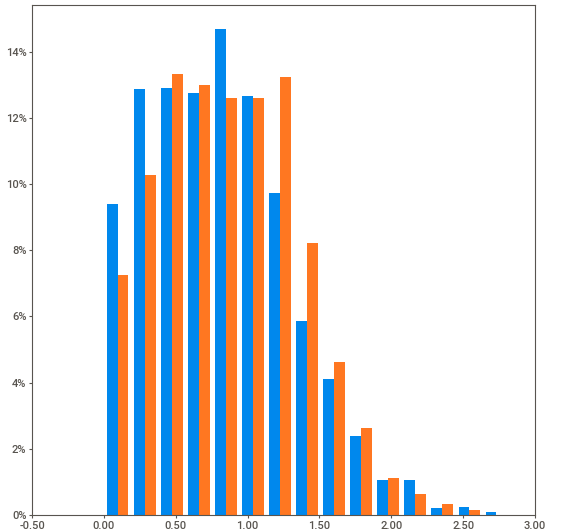
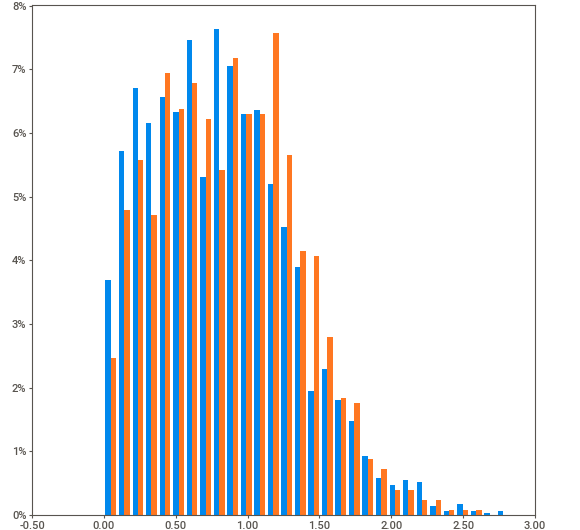
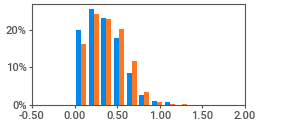
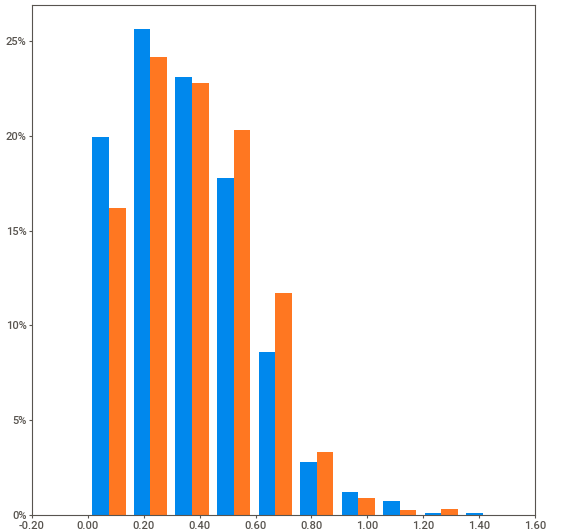
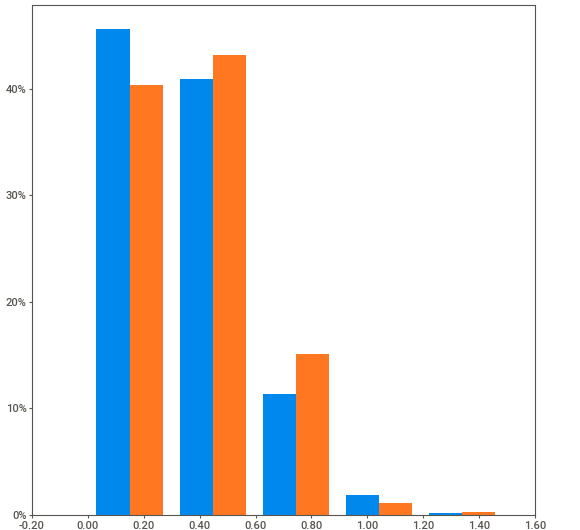
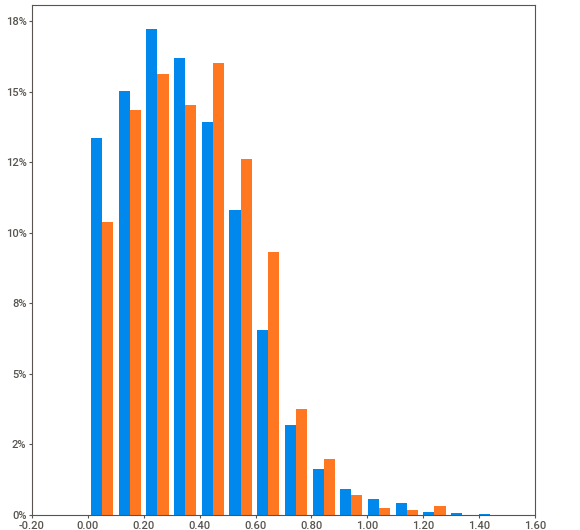
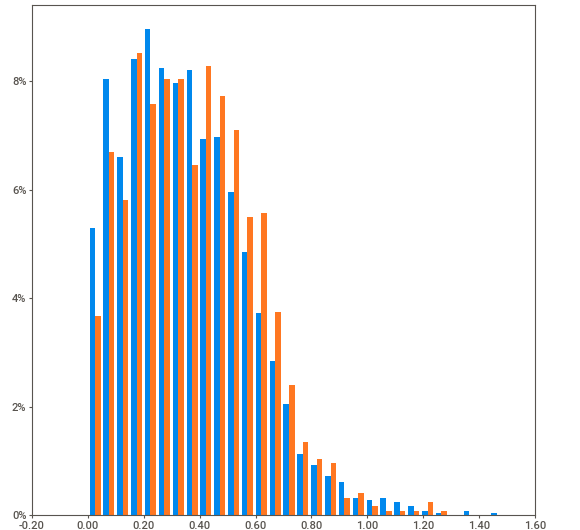
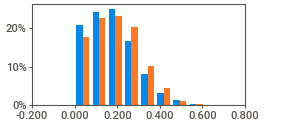
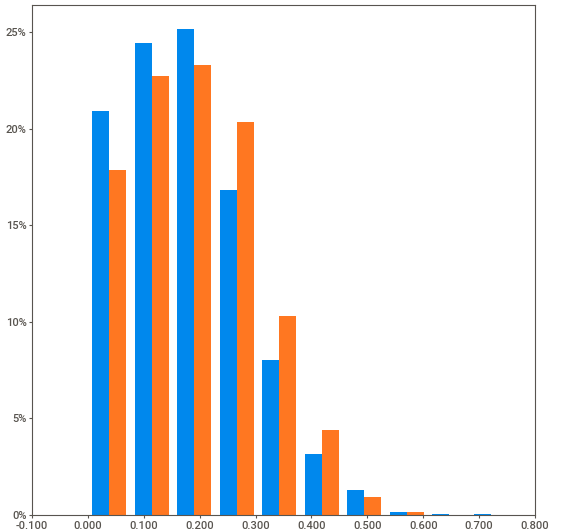
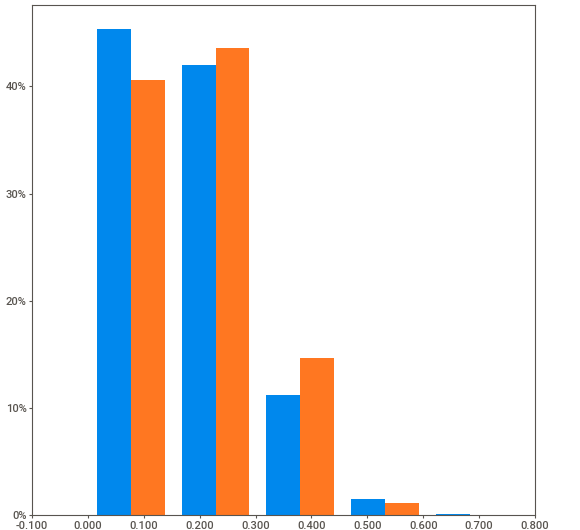
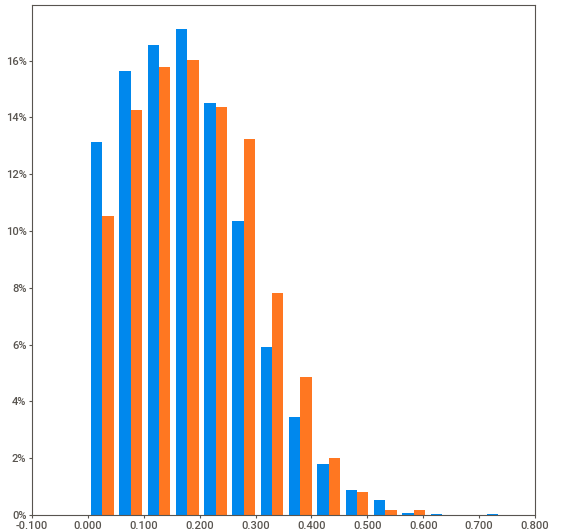
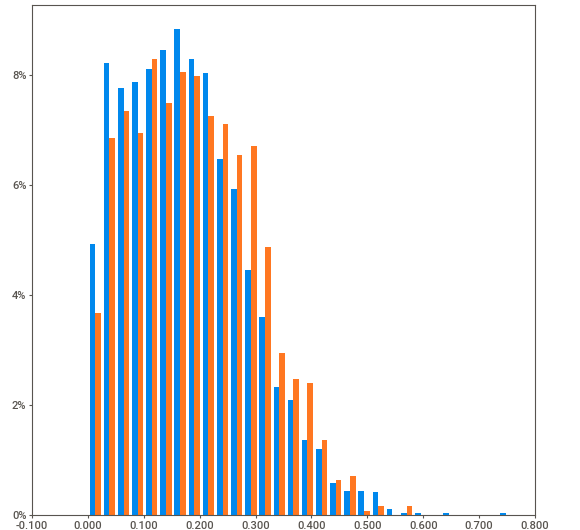
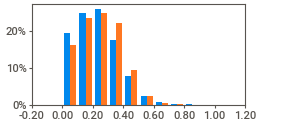
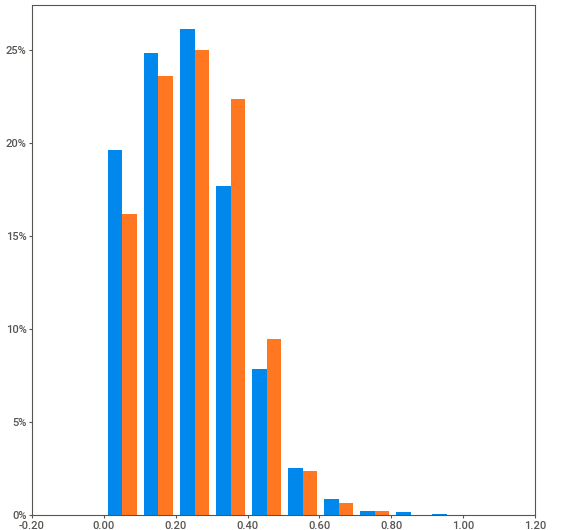
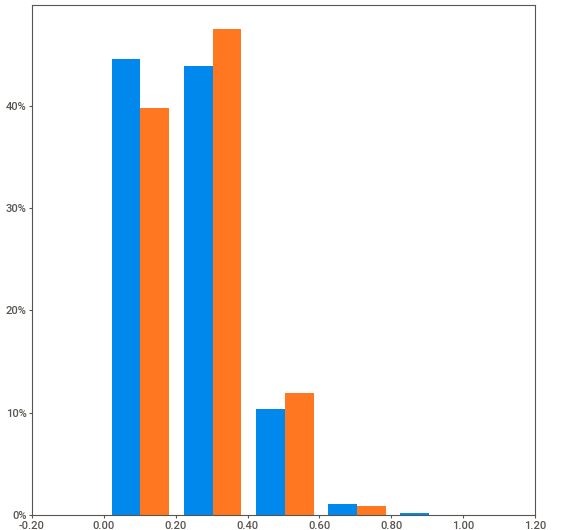
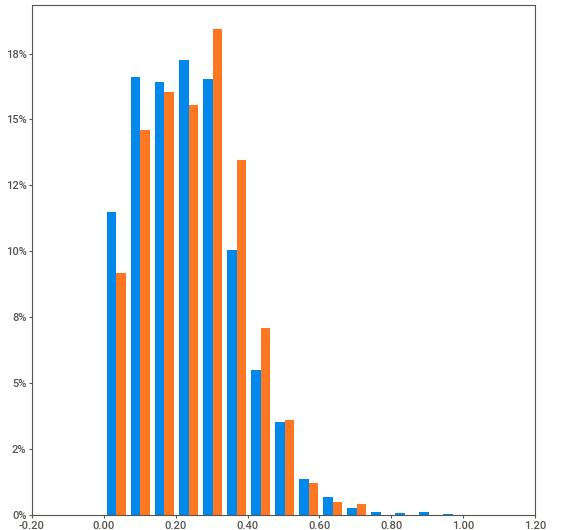
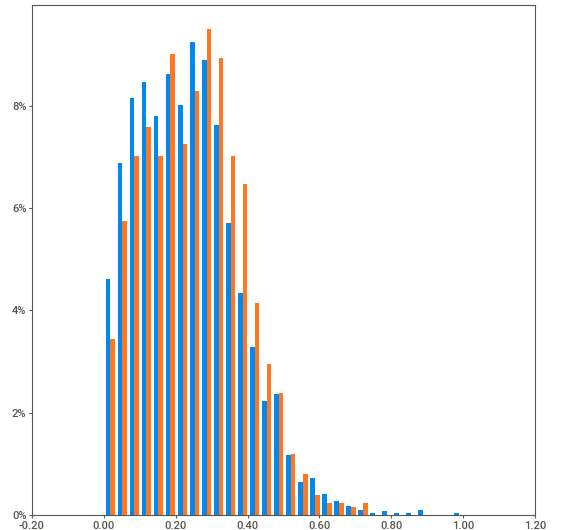
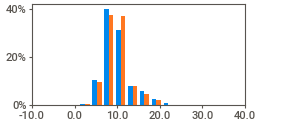
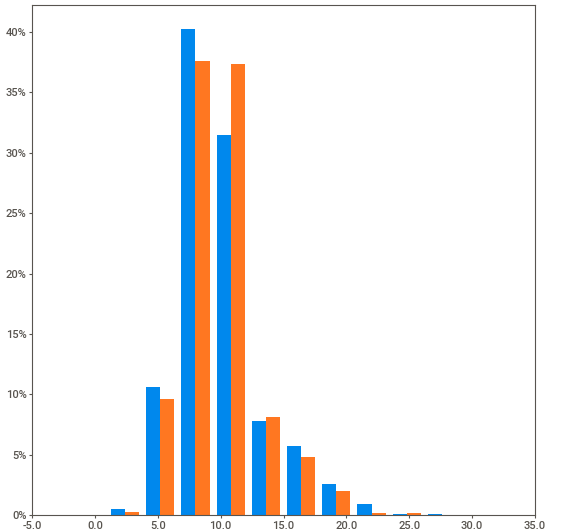
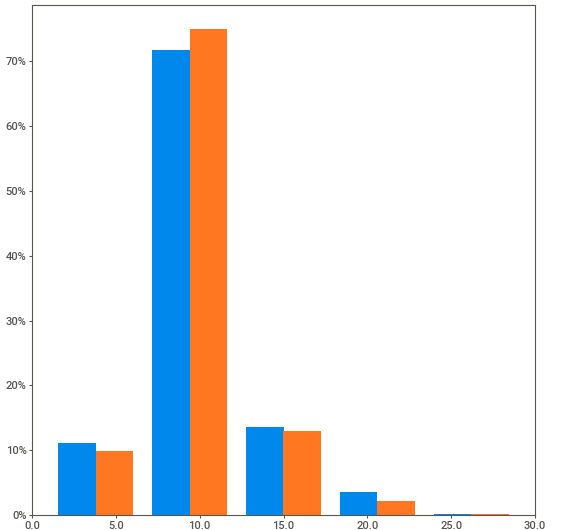
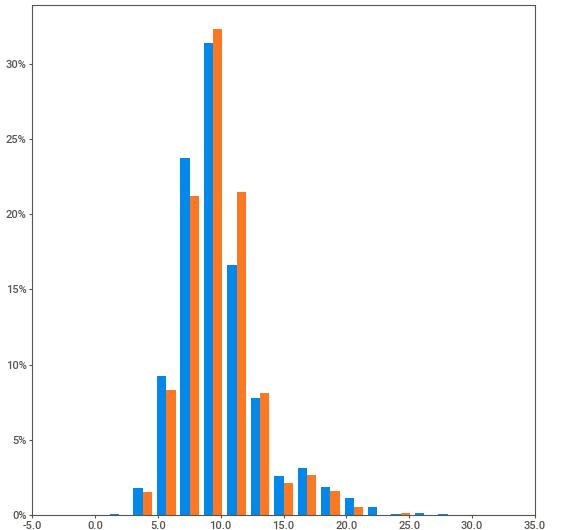
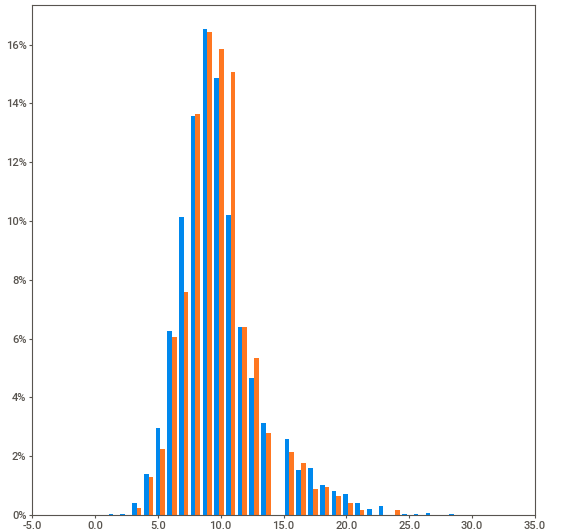
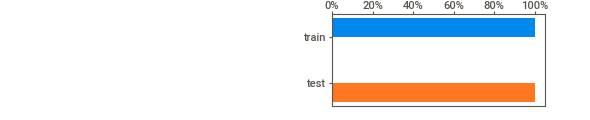
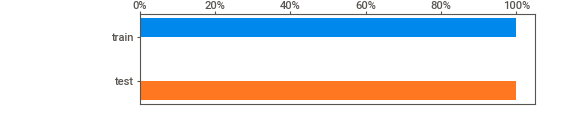
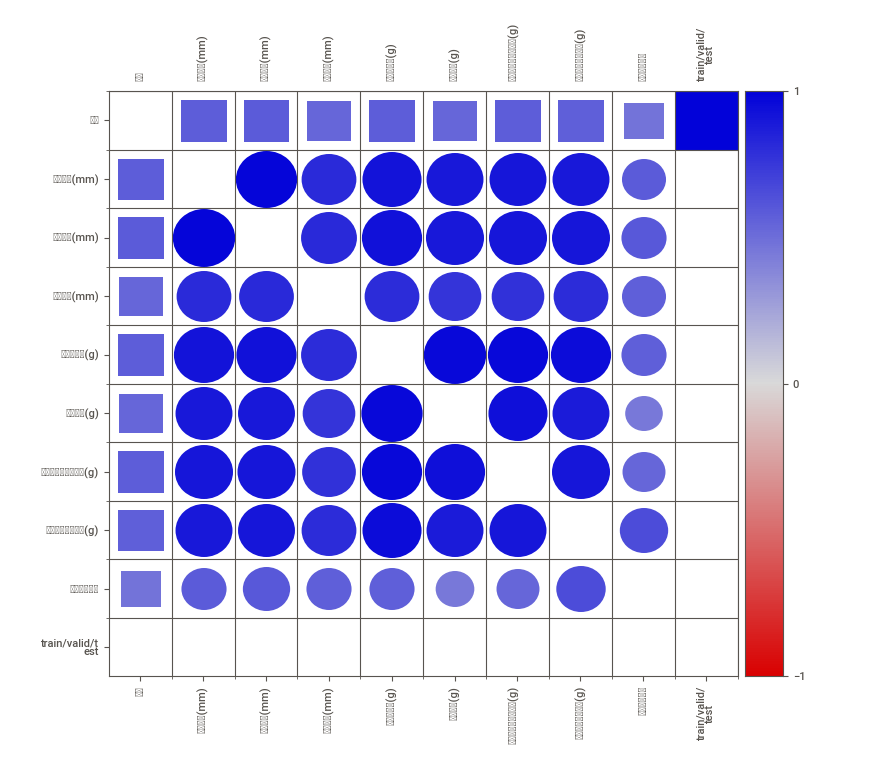
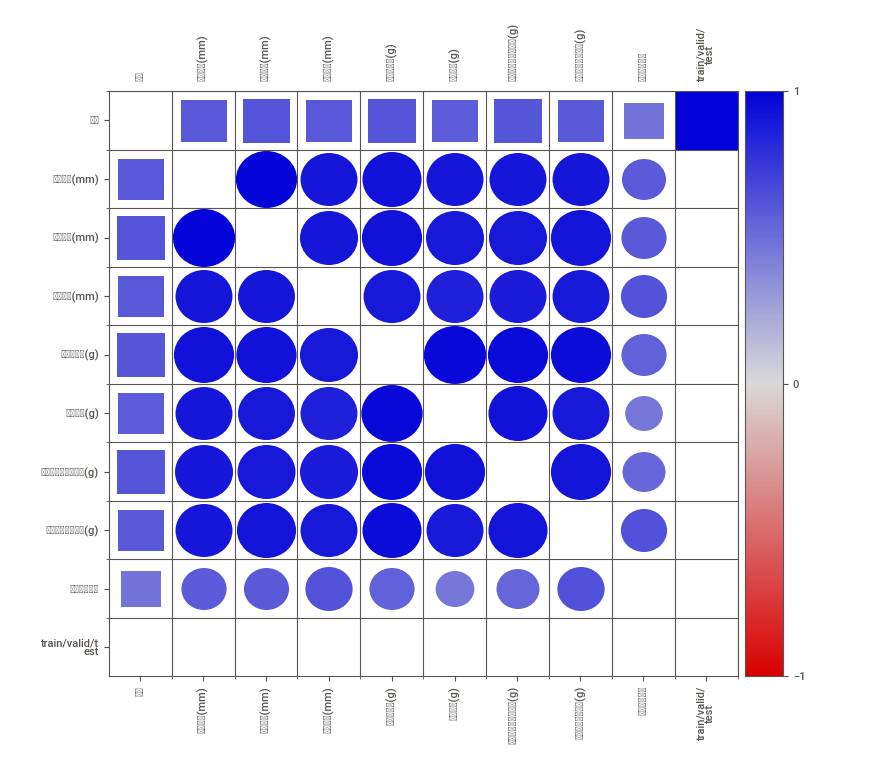

In [7]:
# 各列をまとめて可視化するための準備をする
my_report = sv.compare([df_train, # 訓練データ
                           "Train"], # 表示名
                         [df_test, # テストデータ
                          "Test"]) # 表示名

# 各列の統計量やヒストグラムを可視化
my_report.show_notebook()

## Adversarial Validation によるデータ分割

In [8]:
# 訓練データとテストデータを結合
df_concat = pd.concat([df_train, df_test], axis=0)

In [9]:
# 結合後のデータを確認
df_concat

,性別,殻の長さ(mm),殻の高さ(mm),身の高さ(mm),全体の重さ(g),身の重さ(g),血抜き後の腸の重さ(g),乾燥後の殻の重さ(g),殻の年輪の数,train/valid/test
0,2.0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,train
1,2.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,train
2,0.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,train
3,2.0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,train
4,1.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,train
...,...,...,...,...,...,...,...,...,...,...
4172,0.0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,test
4173,2.0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,test
4174,2.0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,test
4175,0.0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,test


In [10]:
# LightGBM による分類器のインスタンスを作成
adv_clf = LGBMClassifier(random_state=1234, # 乱数を固定するため、シード値を指定
                         n_jobs=-1, # CPU コア数だけ並列計算する
                         importance_type='gain' # 特徴重要度は、情報利得で計算する（デフォルトは分割に用いられた回数）
                         )

In [11]:
# ラベル（train か test か、元の問題の目的変数）を取り除いて、特徴量とする
X = df_concat.drop(['train/valid/test', '殻の年輪の数'], axis=1)

# train か test か、を目的変数とする
y = df_concat['train/valid/test']

# train か test かを分類するモデルを学習
adv_clf.fit(X, # 特徴量
           y, # 目的変数（train か test か）
           categorical_feature=['性別'] # カテゴリ変数の列名を指定（カテゴリ変数であることを加味して分割を決める）
        )

LGBMClassifier(importance_type='gain', random_state=1234)

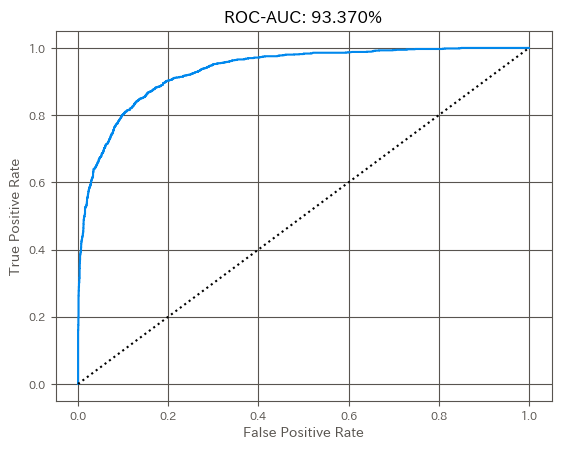

In [12]:
# 日本語の使用を有効化
japanize_matplotlib.japanize()

# ROC 曲線と AUC を表示する関数
def plot_auc_curve(adv_clf, # train か test かを分類する学習済みモデル
                   X, # 特徴量
                   y # 目的変数（train か test か）
                   ):
    # テストデータである確率を得る
    y_pred_proba = adv_clf.predict_proba(X)[:, 0] # [:, 1] なら学習データである確率

    # ROC 曲線の作図に必要な偽陽性率と真陽性率を計算
    false_pos_rate, true_pos_rate, _ = roc_curve(y, # 目的変数
                                                 y_pred_proba, # 確率
                                                 pos_label='test' # 陽性 = test とする
                                                 )
    
    # AUC を計算
    auc_val = auc(false_pos_rate, # 偽陽性率
                  true_pos_rate) # 真陽性率

    # ROC 曲線を可視化
    plt.plot(false_pos_rate, # 横軸 : 偽陽性率
            true_pos_rate) # 縦軸 : 真陽性率
    
    # 最悪ケースの ROC 曲線（完全ランダムに予測したケース）を可視化
    plt.plot(np.arange(0, 1.1, 0.1), # 横軸 : 偽陽性率
            np.arange(0, 1.1, 0.1), # 縦軸 : 真陽性率（偽陽性率と同じ）
            color='black', # 線の色は黒
            linestyle=':') # 線の種類は点線
    
    # グリッドを可視化
    plt.grid(True)

    # 横軸に表示する文字
    plt.xlabel('False Positive Rate')

    # 縦軸に表示する文字
    plt.ylabel('True Positive Rate')

    # 図の上に表示する文字
    plt.title(f'ROC-AUC: {auc_val:.3%}') # % 表記とし、小数点 4 桁目を四捨五入

# ROC 曲線と AUC を可視化
plot_auc_curve(adv_clf, X, y)

# AUC が 90 % を超えている
# = 訓練データとテストデータを見分けられる
# = 訓練データとテストデータで特徴量の分布に違いがある
# （AUC が 50 % 付近なら、訓練データとテストデータの分布は非常に近いといえる）

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

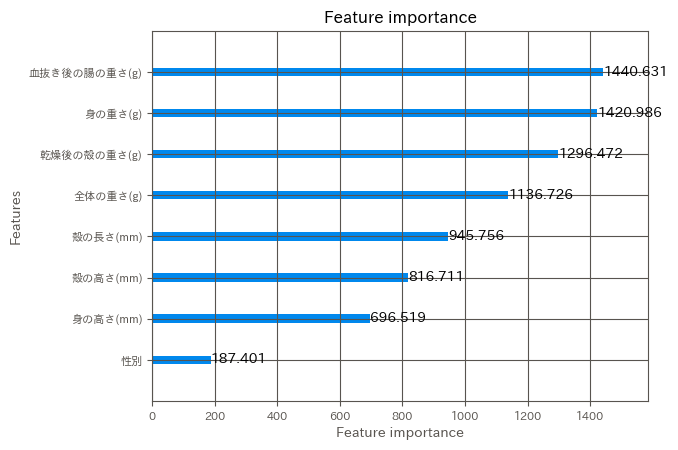

In [13]:
# 特徴量重要度（= 訓練データとテストデータで分布が異なっていそうな特徴量）を可視化
lgb.plot_importance(adv_clf)

In [14]:
# テストデータである確率を踏まえて、検証データを決める関数
def train_valid_split_using_prob(adv_clf, # 学習済みモデル
                                 X, # 学習に用いた特徴量
                                 y, # 学習に用いたラベル
                                 df_train, # 元の訓練データのデータフレーム
                                 valid_size=0.2 # 検証データの割合
                                 ):
    # ラベルが train のデータに対して、テストデータである確率を出力
    y_pred_proba = adv_clf.predict_proba(X[y == 'train'])[:, 0]

    # 検証データのデータ数を計算（訓練データのデータ数 × 検証データの割合）
    valid_data_num = int(len(df_train) * valid_size) # int 関数で整数に丸める
    
    # 確率が高い順にインデックスを並び替え、上位 valid_data_num 件のインデックスを取得 
    idx = np.argsort(y_pred_proba)[::-1][:valid_data_num]

    # 確率上位 valid_data_num 件の ['train/valid/test'] 列の値を valid とする
    df_train.loc[idx, 'train/valid/test'] = 'valid'

    # 検証データを決めたデータフレームを return
    return df_train

In [15]:
# 上記の関数を使って、検証データを決定
df_train_new = train_valid_split_using_prob(adv_clf, X, y, df_train)

In [16]:
# 検証データとして選ばれたデータを確認
df_train_new[df_train_new['train/valid/test'] == 'valid']

,性別,殻の長さ(mm),殻の高さ(mm),身の高さ(mm),全体の重さ(g),身の重さ(g),血抜き後の腸の重さ(g),乾燥後の殻の重さ(g),殻の年輪の数,train/valid/test
1,2.0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,valid
7,0.0,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.2600,16,valid
8,2.0,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.1650,9,valid
11,2.0,0.430,0.350,0.110,0.4060,0.1675,0.0810,0.1350,10,valid
14,0.0,0.470,0.355,0.100,0.4755,0.1675,0.0805,0.1850,10,valid
...,...,...,...,...,...,...,...,...,...,...
2910,2.0,0.580,0.445,0.150,0.9525,0.4315,0.1945,0.2870,11,valid
2913,2.0,0.590,0.500,0.150,1.1420,0.4850,0.2650,0.3450,9,valid
2914,1.0,0.590,0.460,0.125,0.7550,0.3340,0.1500,0.2380,9,valid
2915,1.0,0.590,0.475,0.145,0.9745,0.4675,0.2070,0.2590,10,valid


## モデルの学習と検証データによるハイパーパラメータ調整

In [17]:
# 比較用に訓練データからランダムに 20 % のデータを選択して、検証データとする
df_train_random, df_valid_random = train_test_split(df_train, # 訓練データのデータフレーム
                                                    test_size=0.2, # 検証データの割合
                                                    random_state=1234 # 乱数固定のためのシード値
                                                    )

In [18]:
# Adversarial Validation で訓練データと検証データを分ける
df_train_adv = df_train_new[df_train_new['train/valid/test'] == 'train']
df_valid_adv = df_train_new[df_train_new['train/valid/test'] == 'valid']

In [19]:
# LightGBM で学習とハイパーパラメータ調整を行う関数
def lgbm_train(df_train, # 訓練データ
               df_valid # 検証データ
               ):
    # Optuna のログ表示をできるだけ少なくする
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # 訓練データの特徴量
    X_train = df_train.drop(['殻の年輪の数', 'train/valid/test'], axis=1)

    # 訓練データの目的変数
    y_train = df_train['殻の年輪の数']

    # 検証データの特徴量
    X_valid = df_valid.drop(['殻の年輪の数', 'train/valid/test'], axis=1)
    
    # 検証データの目的変数
    y_valid = df_valid['殻の年輪の数']

    # 訓練データと検証データを LightGBM のデータセット形式に変換
    # （Optuna のハイパーパラメータ調整機能付き LightGBM を使用するための前処理）
    train_set = lgb_opt.Dataset(X_train, # 訓練データの特徴量
                                label=y_train, # 訓練データの目的変数
                                categorical_feature=['性別']) # カテゴリ変数の列名
    valid_set = lgb_opt.Dataset(X_valid, # 検証データの特徴量
                                label=y_valid, # 検証データの目的変数
                                categorical_feature=['性別']) # カテゴリ変数の列名

    # LightGBM の固定するパラメータを辞書で整理
    params = {
        'objective': 'regression', # タスク（今回は回帰）
        'metric': 'mae', # 評価指標（今回はMAE）
        'verbosity': -1, # ログ出力はオフ
        'random_state': 1234, # 乱数固定のシード値
    }

    # Optuna のハイパーパラメータ探索中に実行できないパラメータがサンプルされたときのエラー表示を消す
    with np.errstate(under='ignore'):
        # Optuna のハイパーパラメータ調整機能付き LightGBM でハイパーパラメータ探索
        tuned_model = lgb_opt.train(params, # 固定パラメータ
                                train_set, # 訓練データ
                                valid_sets=valid_set, # 検証データ
                                verbose_eval=False, # ログはオフ
                                num_boost_round=100, # 更新回数
                                show_progress_bar=False, # プログラスバーの表示はオフ
                                optuna_seed=1234 # ハイパーパラメータ探索アルゴリズムのシード値を固定
                                )
    
    # 最も良いハイパーパラメータを取得
    tuned_param = tuned_model.params
    
    # 訓練データと検証データの特徴量を結合
    X = pd.concat([X_train, X_valid], axis=0)

    # 訓練データと検証データの目的変数を結合
    y = pd.concat([y_train, y_valid], axis=0)

    # 最も良いハイパーパラメータを持つ LightGBM のインスタンスを作成
    final_model = LGBMRegressor(random_state=1234, # 乱数を固定するため、シード値を指定
                                  n_jobs=-1 # CPU コア数だけ並列化
                        ).set_params(**tuned_param) # 最も良いハイパーパラメータをセット

    # 学習を実行
    final_model.fit(X, y)

    # 学習済みモデルを return
    return final_model

In [20]:
# ランダムに分割したデータで上記の関数を実行
tuned_model_random = lgbm_train(df_train_random, df_valid_random)

# Adversarial Validation で分割したデータで上記の関数を実行
tuned_model_adv = lgbm_train(df_train_adv, df_valid_adv)

## モデルの評価

In [21]:
# テストデータの特徴量
X_test = df_test.drop(['殻の年輪の数', 'train/valid/test'], axis=1)

# テストデータの目的変数
y_test = df_test['殻の年輪の数']

In [25]:
# テストデータに対する予測と評価指標の計算を行う関数
def test_eval(model, # 学習済みモデル
              X_test, # テストデータの特徴量
              y_test): # テストデータの目的変数

    # テストデータに対する予測値を出力
    y_pred = model.predict(X_test)

    # 予測値と実際の結果から平均絶対値誤差（MAE）を計算
    mae = mean_absolute_error(y_test, # 実際の結果
                              y_pred) # 予測値

    # 予測値と実際の結果から平均絶対値パーセント誤差（MAPE）を計算
    # MAPE = | (予測値 - 実際の値) / (実際の値) | の平均値
    mape = mean_absolute_percentage_error(y_test, # 実際の結果
                                          y_pred) # 予測値

    # 横軸 : 実際の値, 縦軸 : 予測値 として散布図を書く（点が対角に並ぶほど性能◎）
    sns.scatterplot(x=y_test, y=y_pred)

    # 対角線を可視化
    plt.plot(np.arange(0, 25, 0.1), # 横軸
            np.arange(0, 25, 0.1), # 縦軸 
            color='black', # 線の色は黒
            linestyle=':') # 線の種類は点線

    # 散布図の上部に表示するテキスト
    plt.title(f'MAE: {mae:.3f}, MAPE: {mape:.3%}')
    
    # 散布図の横軸に表示するテキスト
    plt.xlabel('殻の年輪の数（実際）')

    # 散布図の縦軸に表示するテキスト
    plt.ylabel('殻の年輪の数（予測）')

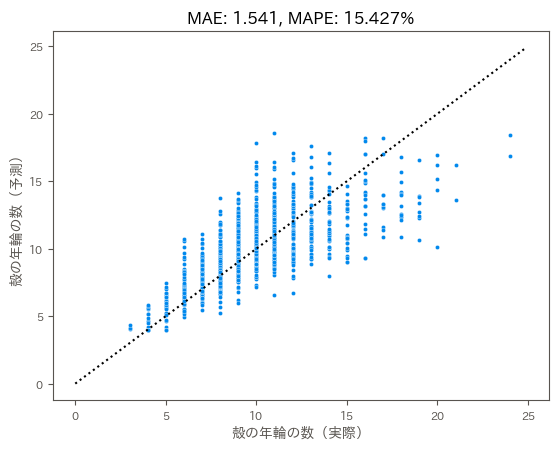

In [26]:
# 上記の関数を使ってランダムにデータ分割した場合のモデルを評価
test_eval(tuned_model_random, X_test, y_test)

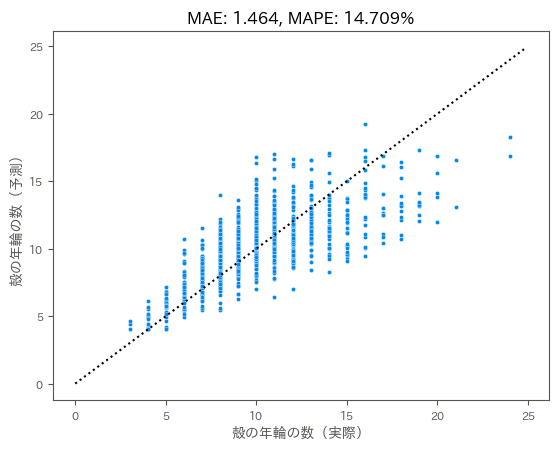

In [27]:
# 上記の関数を使って Adversarial Validation でデータ分割した場合のモデルを評価
test_eval(tuned_model_adv, X_test, y_test)